[How to Develop Convolutional Neural Networks for Multi-Step Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-convolutional-neural-networks-for-multi-step-time-series-forecasting/)
-------------------
This data represents a **multivariate time series** of power-related variables that in turn could be used to model and even forecast future electricity consumption.

Unlike other machine learning algorithms, **convolutional neural networks** are capable of automatically learning features from sequence data, support multiple-variate data, and can directly output a vector for multi-step forecasting. As such, one-dimensional CNNs have been demonstrated to perform well and even achieve state-of-the-art results on challenging sequence prediction problems.

In this tutorial, you will discover how to develop **1D convolutional neural networks** for multi-step time series forecasting.

After completing this tutorial, you will know:
- How to develop a CNN for multi-step time series forecasting model for univariate data.
- How to develop a multichannel multi-step time series forecasting model for multivariate data.
- How to develop a multi-headed multi-step time series forecasting model for multivariate data.

# Tutorial Overview

1. Problem Description
2. Load and Prepare Dataset
3. Model Evaluation
4. CNNs for Multi-Step Forecasting
5. Multi-step Time Series Forecasting With a Univariate CNN
6. Multi-step Time Series Forecasting With a Multichannel CNN
7. Multi-step Time Series Forecasting With a Multihead CNN

# 1 Problem Description
The '[Household Power Consumption](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption)' dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years.

The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute.

It is a multivariate series comprised of seven variables (besides the date and time); they are:

|variable    |Description  |
|:-----------|:------------|
|global_active_power   | The total active power consumed by the household (kilowatts).|
|global_reactive_power | The total reactive power consumed by the household (kilowatts).|
|voltage               | Average voltage (volts).|
|global_intensity      | Average current intensity (amps).|
|sub_metering_1        | Active energy for kitchen (watt-hours of active energy).|
|sub_metering_2        | Active energy for laundry (watt-hours of active energy).|
|sub_metering_3        | Active energy for climate control systems (watt-hours of active energy).|

Active and reactive energy refer to the technical details of alternative current.

A fourth sub-metering variable can be created by subtracting the sum of three defined sub-metering variables from the total active energy as follows:
```
sub_metering_remainder = (global_active_power * 1000 / 60) - (sub_metering_1 + sub_metering_2 + sub_metering_3)
```

# 2 Load and Prepare Dataset
The dataset can be downloaded from the UCI Machine Learning repository as a single 20 megabyte .zip file:

- [household_power_consumption.zip](https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip)

Download the dataset and unzip it into your current working directory. You will now have the file "*household_power_consumption.txt*" that is about 127 megabytes in size and contains all of the observations.

We can use the **read_csv()** function to load the data and combine the first two columns into a single date-time column that we can use as an index.

In [1]:
# load and clean-up data
from numpy import nan
from numpy import isnan
from pandas import read_csv
from pandas import to_numeric

In [ ]:
# load all data
dataset = read_csv('./input/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
dataset.head(10)

Next, we can mark all [missing values](https://machinelearningmastery.com/handle-missing-timesteps-sequence-prediction-problems-python/) indicated with a ‘?‘ character with a NaN value, which is a float.

This will allow us to work with the data as one array of floating point values rather than mixed types (less efficient.)

In [ ]:
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')

We also need to fill in the missing values now that they have been marked.

A very simple approach would be to copy the observation from the same time the day before. We can implement this in a function named **fill_missing()** that will take the NumPy array of the data and copy values from exactly 24 hours ago.

In [ ]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

We can apply this function directly to the data within the DataFrame.

In [ ]:
# fill missing
fill_missing(dataset.values)

Now we can create a new column that contains the remainder of the sub-metering, using the calculation from the previous section.

In [ ]:
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

We can now save the cleaned-up version of the dataset to a new file; in this case we will just change the file extension to .csv and save the dataset as '*household_power_consumption.csv*'.

In [ ]:
# save updated dataset
dataset.to_csv('./input/household_power_consumption.csv')

# 2 Model Evaluation

In this section, we will consider how we can develop and evaluate predictive models for the household power dataset.

This section is divided into four parts; they are:
1. Problem Framing
2. Evaluation Metric
3. Train and Test Sets
4. Walk-Forward Validation

## Problem Framing

There are many ways to harness and explore the household power consumption dataset.

In this tutorial, we will use the data to explore a very specific question; that is:
> Given recent power consumption, what is the expected power consumption for the week ahead?

This requires that a predictive model forecast the total active power for each day over the next seven days.

Technically, this framing of the problem is referred to as a multi-step time series forecasting problem, given the multiple forecast steps. A model that makes use of multiple input variables may be referred to as a multivariate multi-step time series forecasting model.

A model of this type could be helpful within the household in planning expenditures. It could also be helpful on the supply side for planning electricity demand for a specific household.

This framing of the dataset also suggests that it would be useful to downsample the per-minute observations of power consumption to daily totals. This is not required, but makes sense, given that we are interested in total power per day.

We can achieve this easily using the [**resample()**](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) function on the pandas DataFrame. Calling this function with the argument '*D*' allows the loaded data indexed by date-time to be grouped by day ([ee all offset aliases](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)). We can then calculate the sum of all observations for each day and create a new dataset of daily power consumption data for each of the eight variables.

The complete example is listed below.

In [2]:
# resample minute data to total for each day
# from pandas import read_csv
# load the new file
dataset = read_csv('./input/household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('./input/household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

Running the example creates a new daily total power consumption dataset and saves the result into a separate file named `household_power_consumption_days.csv`.

We can use this as the dataset for fitting and evaluating predictive models for the chosen framing of the problem.

## Evaluation Metric

A forecast will be comprised of seven values, one for each day of the week ahead.

It is common with multi-step forecasting problems to evaluate each forecasted time step separately. This is helpful for a few reasons:
- To comment on the skill at a specific lead time (e.g. +1 day vs +3 days).
- To contrast models based on their skills at different lead times (e.g. models good at +1 day vs models good at days +5).

The units of the total power are kilowatts and it would be useful to have an error metric that was also in the same units. Both Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) fit this bill, although RMSE is more commonly used and will be adopted in this tutorial. Unlike MAE, RMSE is more punishing of forecast errors.

The performance metric for this problem will be the RMSE for each lead time from day 1 to day 7.

As a short-cut, it may be useful to summarize the performance of a model using a single score in order to aide in model selection.

One possible score that could be used would be the RMSE across all forecast days.

The function evaluate_forecasts() below will implement this behavior and return the performance of a model based on multiple seven-day forecasts.

In [3]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

Running the function will first return the overall RMSE regardless of day, then an array of RMSE scores for each day.
## Train and Test Sets

We will use the first three years of data for training predictive models and the final year for evaluating models.

The data in a given dataset will be divided into standard weeks. These are weeks that begin on a Sunday and end on a Saturday.

This is a realistic and useful way for using the chosen framing of the model, where the power consumption for the week ahead can be predicted. It is also helpful with modeling, where models can be used to predict a specific day (e.g. Wednesday) or the entire sequence.

We will split the data into standard weeks, working backwards from the test dataset.

The final year of the data is in 2010 and the first Sunday for 2010 was January 3rd. The data ends in mid November 2010 and the closest final Saturday in the data is November 20th. This gives 46 weeks of test data.

The first and last rows of daily data for the test dataset are provided below for confirmation.
```
2010-01-03,2083.4539999999984,191.61000000000055,350992.12000000034,8703.600000000033,3842.0,4920.0,10074.0,15888.233355799992
...
2010-11-20,2197.006000000004,153.76800000000028,346475.9999999998,9320.20000000002,4367.0,2947.0,11433.0,17869.76663959999
```
The daily data starts in late 2006.

The first Sunday in the dataset is December 17th, which is the second row of data.

Organizing the data into standard weeks gives 159 full standard weeks for training a predictive model.
```
2006-12-17,3390.46,226.0059999999994,345725.32000000024,14398.59999999998,2033.0,4187.0,13341.0,36946.66673200004
...
2010-01-02,1309.2679999999998,199.54600000000016,352332.8399999997,5489.7999999999865,801.0,298.0,6425.0,14297.133406600002
```
The function **split_dataset()** below splits the daily data into train and test sets and organizes each into standard weeks.

Specific row offsets are used to split the data using knowledge of the dataset. The split datasets are then organized into weekly data using the NumPy [**split()**](https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html) function.

In [4]:
# split into standard weeks
from numpy import split
from numpy import array

In [5]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

We can test this function out by loading the daily dataset and printing the first and last rows of data from both the train and test sets to confirm they match the expectations above.

Running the example shows that indeed the train dataset has 159 weeks of data, whereas the test dataset has 46 weeks.

We can see that the total active power for the train and test dataset for the first and last rows match the data for the specific dates that we defined as the bounds on the standard weeks for each set.

In [6]:
# load the new file
dataset = read_csv('./input/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


In [7]:
from math import sqrt

from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


## Walk-Forward Validation

Models will be evaluated using a scheme called [walk-forward validation.](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week. This is both realistic for how the model may be used in practice and beneficial to the models, allowing them to make use of the best available data.

We can demonstrate this below with separation of input data and output/predicted data.
```
Input, 						Predict
[Week1]						Week2
[Week1 + Week2]				Week3
[Week1 + Week2 + Week3]		Week4
...
```
The walk-forward validation approach to evaluating predictive models on this dataset is provided below, named **evaluate_model()**.

The train and test datasets in standard-week format are provided to the function as arguments. An additional argument, n_input, is provided that is used to define the number of prior observations that the model will use as input in order to make a prediction.

Two new functions are called: one to build a model from the training data called **build_model()** and another that uses the model to make forecasts for each new standard week, called **forecast()**. These will be covered in subsequent sections.

We are working with neural networks and as such they are generally slow to train but fast to evaluate. This means that the preferred usage of the models is to build them once on historical data and to use them to forecast each step of the walk-forward validation. The models are static (i.e. not updated) during their evaluation.

This is different to other models that are faster to train, where a model may be re-fit or updated each step of the walk-forward validation as new data is made available. With sufficient resources, it is possible to use neural networks this way, but we will not in this tutorial.

The complete **evaluate_model()** function is listed below.

In [8]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

Once we have the evaluation for a model, we can summarize the performance.

The function below, named **summarize_scores()**, will display the performance of a model as a single line for easy comparison with other models.

In [9]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

We now have all of the elements to begin evaluating predictive models on the dataset.
# 3 CNNs for Multi-Step Forecasting

Convolutional Neural Network models, or CNNs for short, are a type of deep neural network that was developed for use with image data, such as handwriting recognition.

They are proven very effective on challenging computer vision problems when trained at scale for tasks such as identifying and localizing objects in images and automatically describing the content of images.

They are a model that are comprised of two main types of elements: convolutional layers and pooling layers.

***Convolutional layers*** read an input, such as a 2D image or a 1D signal using a kernel that reads in small segments at a time and steps across the entire input field. Each read results in an interpretation of the input that is projected onto a filter map and represents an interpretation of the input.

***Pooling layers*** take the feature map projections and distill them to the most essential elements, such as using a signal averaging or signal maximizing process.

The convolution and pooling layers can be repeated at depth, providing multiple layers of abstraction of the input signals.

The output of these networks is often one or more fully-connected layers that interpret what has been read and maps this internal representation to a class value.

For more information on convolutional neural networks, you can see the post:
- [Crash Course in Convolutional Neural Networks for Machine Learning](https://machinelearningmastery.com/crash-course-convolutional-neural-networks/)

Convolutional neural networks can be used for multi-step time series forecasting.
- The convolutional layers can read sequences of input data and automatically extract features.
- The pooling layers can distill the extracted features and focus attention on the most salient elements.
- The fully connected layers can interpret the internal representation and output a vector representing multiple time steps.

The key benefits of the approach are the automatic feature learning and the ability of the model to output a multi-step vector directly.

CNNs can be used in either a recursive or direct forecast strategy, where the model makes one-step predictions and outputs are fed as inputs for subsequent predictions, and where one model is developed for each time step to be predicted. Alternately, CNNs can be used to predict the entire output sequence as a one-step prediction of the entire vector. This is a general benefit of feed-forward neural networks.

An important secondary benefit of using CNNs is that they can support multiple 1D inputs in order to make a prediction. This is useful if the multi-step output sequence is a function of more than one input sequence. This can be achieved using two different model configurations.
- **Multiple Input Channels.** This is where each input sequence is read as a separate channel, like the different channels of an image (e.g. red, green and blue).
- **Multiple Input Heads.** This is where each input sequence is read by a different CNN sub-model and the internal representations are combined before being interpreted and used to make a prediction.

In this tutorial, we will explore how to develop three different types of CNN models for multi-step time series forecasting; they are:
- A CNN for multi-step time series forecasting with univariate input data.
- A CNN for multi-step time series forecasting with multivariate input data via channels.
- A CNN for multi-step time series forecasting with multivariate input data via submodels.

The models will be developed and demonstrated on the household power prediction problem. A model is considered skillful if it achieves performance better than a naive model, which is an overall RMSE of about 465 kilowatts across a seven day forecast.

We will not focus on the tuning of these models to achieve optimal performance; instead we will sill stop short at skillful models as compared to a naive forecast. The chosen structures and hyperparameters are chosen with a little trial and error.
# 5 Multi-step Time Series Forecasting With a Univariate CNN

In this section, we will develop a convolutional neural network for multi-step time series forecasting using only the univariate sequence of daily power consumption.

Specifically, the framing of the problem is:
> Given some number of prior days of total daily power consumption, predict the next standard week of daily power consumption.

The number of prior days used as input defines the one-dimensional (1D) subsequence of data that the CNN will read and learn to extract features. Some ideas on the size and nature of this input include:
- All prior days, up to years worth of data.
- The prior seven days.
- The prior two weeks.
- The prior one month.
- The prior one year.
- The prior week and the week to be predicted from one year ago.

There is no right answer; instead, each approach and more can be tested and the performance of the model can be used to choose the nature of the input that results in the best model performance.

These choices define a few things about the implementation, such as:
- How the training data must be prepared in order to fit the model.
- How the test data must be prepared in order to evaluate the model.
- How to use the model to make predictions with a final model in the future.

A good starting point would be to use the prior seven days.

A 1D CNN model expects data to have the shape of:
```
[samples, timesteps, features]
```
One sample will be comprised of seven time steps with one feature for the seven days of total daily power consumed.

The training dataset has 159 weeks of data, so the shape of the training dataset would be:
```
[159, 7, 1]
```
This is a good start. The data in this format would use the prior standard week to predict the next standard week. A problem is that 159 instances is not a lot for a neural network.

A way to create a lot more training data is to change the problem during training to predict the next seven days given the prior seven days, regardless of the standard week.

This only impacts the training data, the test problem remains the same: predict the daily power consumption for the next standard week given the prior standard week.

This will require a little preparation of the training data.

The training data is provided in standard weeks with eight variables, specifically in the shape \[159, 7, 8\]. The first step is to flatten the data so that we have eight time series sequences.
```python
# flatten data
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
```
We then need to iterate over the time steps and divide the data into overlapping windows; each iteration moves along one time step and predicts the subsequent seven days.

For example:
```
Input, Output
[d01, d02, d03, d04, d05, d06, d07],	[d08, d09, d10, d11, d12, d13, d14]
[d02, d03, d04, d05, d06, d07, d08],	[d09, d10, d11, d12, d13, d14, d15]
...
```
We can do this by keeping track of start and end indexes for the inputs and outputs as we iterate across the length of the flattened data in terms of time steps.

We can also do this in a way where the number of inputs and outputs are parameterized (e.g. n_input, n_out) so that you can experiment with different values or adapt it for your own problem.

Below is a function named **to_supervised()** that takes a list of weeks (history) and the number of time steps to use as inputs and outputs and returns the data in the overlapping moving window format.

In [10]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

When we run this function on the entire training dataset, we transform 159 samples into 1,099; specifically, the transformed dataset has the shapes `X=[1099, 7, 1]` and `y=[1099, 7]`.

Next, we can define and fit the CNN model on the training data.

This multi-step time series forecasting problem is an autoregression. That means it is likely best modeled where that the next seven days is some function of observations at prior time steps. This and the relatively small amount of data means that a small model is required.

We will use a model with one convolution layer with 16 filters and a kernel size of 3. This means that the input sequence of seven days will be read with a convolutional operation three time steps at a time and this operation will be performed 16 times. A pooling layer will reduce these feature maps by 1/4 their size before the internal representation is flattened to one long vector. This is then interpreted by a fully connected layer before the output layer predicts the next seven days in the sequence.

We will use the mean squared error loss function as it is a good match for our chosen error metric of RMSE. We will use the efficient [ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) implementation of stochastic gradient descent and fit the model for 20 epochs with a batch size of 4.

The small batch size and the stochastic nature of the algorithm means that the same model will learn a slightly different mapping of inputs to outputs each time it is trained. This means [results may vary when the model is evaluated](https://machinelearningmastery.com/randomness-in-machine-learning/). You can try running the model multiple times and calculating an average of model performance.

The build_model() below prepares the training data, defines the model, and fits the model on the training data, returning the fit model ready for making predictions.

In [11]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 4
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(10, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

Now that we know how to fit the model, we can look at how the model can be used to make a prediction.

Generally, the model expects data to have the same three dimensional shape when making a prediction.

In this case, the expected shape of an input pattern is one sample, seven days of one feature for the daily power consumed:
```
[1, 7, 1]
```
Data must have this shape when making predictions for the test set and when a final model is being used to make predictions in the future. If you change the number of input days to 14, then the shape of the training data and the shape of new samples when making predictions must be changed accordingly to have 14 time steps. It is a modeling choice that you must carry forward when using the model.

We are using walk-forward validation to evaluate the model as described in the previous section.

This means that we have the observations available for the prior week in order to predict the coming week. These are collected into an array of standard weeks, called history.

In order to predict the next standard week, we need to retrieve the last days of observations. As with the training data, we must first flatten the history data to remove the weekly structure so that we end up with eight parallel time series.
```python
# flatten data
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
```
Next, we need to retrieve the last seven days of daily total power consumed (feature number 0). We will parameterize as we did for the training data so that the number of prior days used as input by the model can be modified in the future.
```python
# retrieve last observations for input data
input_x = data[-n_input:, 0]
```
Next, we reshape the input into the expected three-dimensional structure.
```python
# reshape into [1, n_input, 1]
input_x = input_x.reshape((1, len(input_x), 1))
```
We then make a prediction using the fit model and the input data and retrieve the vector of seven days of output.
```python
# forecast the next week
yhat = model.predict(input_x, verbose=0)
# we only want the vector forecast
yhat = yhat[0]
```
The **forecast()** function below implements this and takes as arguments the model fit on the training dataset, the history of data observed so far, and the number of inputs time steps expected by the model.

In [12]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

That’s it; we now have everything we need to make multi-step time series forecasts with a CNN model on the daily total power consumed univariate dataset.

Running the example fits and evaluates the model, printing the overall RMSE across all seven days, and the per-day RMSE for each lead time.

Your specific results may vary given the stochastic nature of the algorithm. You may want to try running the example a few times.

We can see that in this case, the model was skillful as compared to a naive forecast, achieving an overall RMSE of about 404 kilowatts, less than 465 kilowatts achieved by a naive model.
```
cnn: [404.411] 436.1, 400.6, 346.2, 388.2, 405.5, 326.0, 502.9
```

In [13]:
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)

cnn: [391.783] 421.6, 392.4, 351.5, 380.3, 398.6, 318.9, 462.6


A plot of the daily RMSE is also created. The plot shows that perhaps Tuesdays and Fridays are easier days to forecast than the other days and that perhaps Saturday at the end of the standard week is the hardest day to forecast.

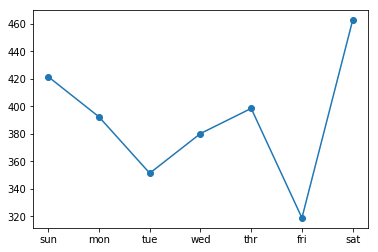

In [14]:
from matplotlib import pyplot
%matplotlib inline
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

We can increase the number of prior days to use as input from seven to 14 by changing the `n_input` variable.
```python
# evaluate model and get scores
n_input = 14
```
Re-running the example with this change first prints a summary of the performance of the model.

Your specific results may vary; try running the example a few times.

In this case, we can see a further drop in the overall RMSE, suggesting that further tuning of the input size and perhaps the kernel size of the model may result in better performance.
```
cnn: [396.497] 392.2, 412.8, 384.0, 389.0, 387.3, 381.0, 427.1
```
Comparing the per-day RMSE scores, we see some are better and some are worse than using seventh inputs.

This may suggest a benefit in using the two different sized inputs in some way, such as an ensemble of the two approaches or perhaps a single model (e.g. a multi-headed model) that reads the training data in different ways.

# 6 Multi-step Time Series Forecasting With a Multichannel CNN

In this section, we will update the CNN developed in the previous section to use each of the eight time series variables to predict the next standard week of daily total power consumption.

We will do this by providing each one-dimensional time series to the model as a separate channel of input.

The CNN will then use a separate kernel and read each input sequence onto a separate set of filter maps, essentially learning features from each input time series variable.

This is helpful for those problems where the output sequence is some function of the observations at prior time steps from multiple different features, not just (or including) the feature being forecasted. It is unclear whether this is the case in the power consumption problem, but we can explore it nonetheless.

First, we must update the preparation of the training data to include all of the eight features, not just the one total daily power consumed. It requires a single line:
```python
X.append(data[in_start:in_end, :])
```
The complete **to_supervised()** function with this change is listed below.

In [15]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

We also must update the function used to make forecasts with the fit model to use all eight features from the prior time steps. Again, another small change:
```python
# retrieve last observations for input data
input_x = data[-n_input:, :]
# reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
```
The complete **forecast()** with this change is listed below:

In [16]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

We will use 14 days of prior observations across eight of the input variables as we did in the final section of the prior section that resulted in slightly better performance.
```python
n_input = 14
```
Finally, the model used in the previous section does not perform well on this new framing of the problem.

The increase in the amount of data requires a larger and more sophisticated model that is trained for longer.

With a little trial and error, one model that performs well uses two convolutional layers with 32 filter maps followed by pooling, then another convolutional layer with 16 feature maps and pooling. The fully connected layer that interprets the features is increased to 100 nodes and the model is fit for 70 epochs with a batch size of 16 samples.

The updated build_model() function that defines and fits the model on the training dataset is listed below.

In [17]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

We now have all of the elements required to develop a multi-channel CNN for multivariate input data to make multi-step time series forecasts.

Running the example fits and evaluates the model, printing the overall RMSE across all seven days, and the per-day RMSE for each lead time.

Your specific results may vary given the stochastic nature of the algorithm. You may want to try running the example a few times.

We can see that in this case, the use of all eight input variables does result in another small drop in the overall RMSE score.
```
cnn: [385.711] 422.2, 363.5, 349.8, 393.1, 357.1, 318.8, 474.3
```

In [18]:
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)

cnn: [472.836] 477.6, 422.6, 431.0, 542.0, 461.5, 383.5, 564.6


For the daily RMSE scores, we do see that some are better and some are worse than the univariate CNN from the previous section.

The final day, Saturday, remains a challenging day to forecast, and Friday an easy day to forecast. There may be some benefit in designing models to focus specifically on reducing the error of the harder to forecast days.

It may be interesting to see if the variance across daily scores could be further reduced with a tuned model or perhaps an ensemble of multiple different models. It may also be interesting to compare the performance for a model that uses seven or even 21 days of input data to see if further gains can be made.

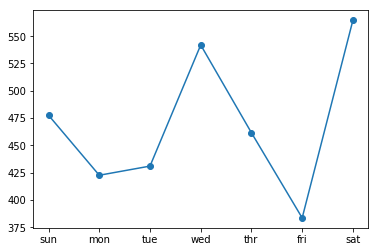

In [19]:
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

# 7 Multi-step Time Series Forecasting With a Multihead CNN

We can further extend the CNN model to have a separate sub-CNN model or head for each input variable, which we can refer to as a multi-headed CNN model.

This requires a modification to the preparation of the model, and in turn, modification to the preparation of the training and test datasets.

Starting with the model, we must define a separate CNN model for each of the eight input variables.

The configuration of the model, including the number of layers and their hyperparameters, were also modified to better suit the new approach. The new configuration is not optimal and was found with a little trial and error.

The multi-headed model is specified using the more flexible [functional API for defining Keras models](https://machinelearningmastery.com/keras-functional-api-deep-learning/).

We can loop over each variable and create a sub-model that takes a one-dimensional sequence of 14 days of data and outputs a flat vector containing a summary of the learned features from the sequence. Each of these vectors can be merged via concatenation to make one very long vector that is then interpreted by some fully connected layers before a prediction is made.

As we build up the submodels, we keep track of the input layers and flatten layers in lists. This is so that we can specify the inputs in the definition of the model object and use the list of flatten layers in the merge layer.
```python
# create a channel for each variable
in_layers, out_layers = list(), list()
for i in range(n_features):
	inputs = Input(shape=(n_timesteps,1))
	conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
	conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
	pool1 = MaxPooling1D(pool_size=2)(conv2)
	flat = Flatten()(pool1)
	# store layers
	in_layers.append(inputs)
	out_layers.append(flat)
# merge heads
merged = concatenate(out_layers)
# interpretation
dense1 = Dense(200, activation='relu')(merged)
dense2 = Dense(100, activation='relu')(dense1)
outputs = Dense(n_outputs)(dense2)
model = Model(inputs=in_layers, outputs=outputs)
# compile model
model.compile(loss='mse', optimizer='adam')
```
When the model is used, it will require eight arrays as input: one for each of the submodels.

This is required when training the model, when evaluating the model, and when making predictions with a final model.

We can achieve this by creating a list of 3D arrays, where each 3D array contains \[samples, timesteps, 1\], with one feature.

We can prepare the training dataset in this format as follows:
```python
input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
```
The updated **build_model()** function with these changes is listed below.

In [20]:
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate

In [21]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 25, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# create a channel for each variable
	in_layers, out_layers = list(), list()
	for i in range(n_features):
		inputs = Input(shape=(n_timesteps,1))
		conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
		conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
		pool1 = MaxPooling1D(pool_size=2)(conv2)
		flat = Flatten()(pool1)
		# store layers
		in_layers.append(inputs)
		out_layers.append(flat)
	# merge heads
	merged = concatenate(out_layers)
	# interpretation
	dense1 = Dense(200, activation='relu')(merged)
	dense2 = Dense(100, activation='relu')(dense1)
	outputs = Dense(n_outputs)(dense2)
	model = Model(inputs=in_layers, outputs=outputs)
	# compile model
	model.compile(loss='mse', optimizer='adam')
	# plot the model
	# plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
	# fit network
	input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
	model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

When the model is built, a diagram of the structure of the model is created and saved to file.

***Note:*** the call to **plot_model()** requires that `pygraphviz` and `pydot` are installed. If this is a problem, you can comment out this line.

The structure of the network looks as follows.
![Structure of the Multi Headed Convolutional Neural Network](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/07/Structure-of-the-Multiheaded-Convolutional-Neural-Network.png)
Next, we can update the preparation of input samples when making a prediction for the test dataset.

We must perform the same change, where an input array of \[1, 14, 8\] must be transformed into a list of eight 3D arrays each with \[1, 14, 1\].
```python
input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
```
The **forecast()** function with this change is listed below.

In [22]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into n input arrays
	input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

Running the example fits and evaluates the model, printing the overall RMSE across all seven days, and the per-day RMSE for each lead time.

Your specific results may vary given the stochastic nature of the algorithm. You may want to try running the example a few times.

We can see that in this case, the overall RMSE is skillful compared to a naive forecast, but with the chosen configuration may not perform better than the multi-channel model in the previous section.
```
cnn: [396.116] 414.5, 385.5, 377.2, 412.1, 371.1, 380.6, 428.1
```

In [23]:
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)

cnn: [403.516] 445.3, 406.1, 358.6, 396.9, 425.7, 330.5, 447.2


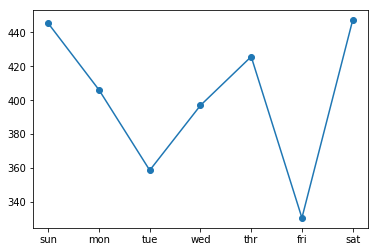

In [24]:
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

We can also see a different, more pronounced profile for the daily RMSE scores where perhaps Mon-Tue and Thu-Fri are easier for the model to predict than the other forecast days.

These results may be useful when combined with another forecast model.

It may be interesting to explore alternate methods in the architecture for merging the output of each sub-model.

# Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.
- **Size of Input.** Explore more or fewer numbers of days used as input for the model, such as three days, 21 days, 30 days and more.
- **Model Tuning.** Tune the structure and hyperparameters for a model and further lift model performance on average.
- **Data Scaling.** Explore whether data scaling, such as standardization and normalization, can be used to improve the performance of any of the CNN models.
- **Learning Diagnostics.** Use diagnostics such as learning curves for the train and validation loss and mean squared error to help tune the structure and hyperparameters of a CNN model.
- **Vary Kernel Size.** Combine the multichannel CNN with the multi-headed CNN and use a different kernel size for each head to see if this configuration can further improve performance.

If you explore any of these extensions, I’d love to know.
# Summary

In this tutorial, you discovered how to develop 1D convolutional neural networks for multi-step time series forecasting.

Specifically, you learned:
- How to develop a CNN for multi-step time series forecasting model for univariate data.
- How to develop a multichannel multi-step time series forecasting model for multivariate data.
- How to develop a multi-headed multi-step time series forecasting model for multivariate data.
